# <center>UC Berkeley School of Information | MIDS Program</center>
# <center>w261 Final Project, Fall 2018</center>
## <center>Group 5, Saturday Sections:  Jooyeon (Irene) Seo, Arturo Esquerra, Mark Barnett, Shahbakht Hamdani</center>

### Cluster performance tested on IBM Analytics Engine running 3 nodes
>Technical Information: https://console.bluemix.net/docs/services/AnalyticsEngine/index.html#introduction

>Marketing Information:  https://www.ibm.com/cloud/analytics-engine/faq 

>For access to cluster please let us know to add you as a collaborator

>Tech Specs for IBM Cluster:  
Components
Apache Spark 2.3.0
Hadoop 2.7.3
Jupyter Enterprise Gateway 0.8.0
Apache Livy 0.3.0
Knox 0.12.0
Ambari 2.6.2
Anaconda-Py 2.7.13 and 3.5.2
HBase 1.1.2
Hive 1.2.1
Oozie 4.2.0
Flume 1.5.2
Apache Phoenix 4.7

### Preface - Load Libraries and Start Spark Session

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression


In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261_final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

# 0. Data Preparation

In [ ]:
# Create Directory - DO NOT RUN
# Create Local Data Directory
!mkdir data

In [ ]:
# download the zip file - DO NOT RUN
# Download File to Local File Directory
!wget -q -O data/dac.tar.gz https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz

In [ ]:
# unpack the file - DO NOT RUN
# Unzip File to Local File Structure into /data
!tar -xvzf data/dac.tar.gz -C data

In [4]:
# Peek at file contents
!head -1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [5]:
# Load files into SparkContext - INSTRUCTORS PLEASE UPDATE TO RUBRIC TRAIN.TXT FILE LOCATION

# Create Data Directory in HDFS
!hdfs dfs -mkdir data

# Upload files to HDFS from local/data
!hdfs dfs -put /home/wce/clsadmin/data/test.txt /data/
!hdfs dfs -put /home/wce/clsadmin/data/train.txt /data/

!hdfs dfs -ls /data/

mkdir: `data': File exists
put: `/data/test.txt': File exists
put: `/data/train.txt': File exists
Found 2 items
-rw-r--r--   3 clsadmin bihdfs  1460246311 2018-12-10 08:47 /data/test.txt
-rw-r--r--   3 clsadmin bihdfs 11147184845 2018-12-10 08:49 /data/train.txt


In [6]:
!hdfs dfs -cat /data/train.txt | head -1

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
cat: Unable to write to output stream.


In [4]:
# Load files into SparkContext

# local computer (comment out on cluster)
# testRDD = sc.textFile('data\test.txt')
# trainFullRDD = sc.textFile('data/train.txt')

# Cluster (comment out on local compute)
testRDD = sc.textFile('data/test.txt')
trainFullRDD = sc.textFile('hdfs:///data/train.txt')
testRDD = sc.textFile('hdfs:///data/test.txt')

print("Data set contains {:,} records".format(trainFullRDD.count()))

Data set contains 45,840,617 records


In [5]:
def parse(line):
    payload = line.split('\t')
    label, intfeatures, catfeatures = payload[0], payload[1:14], payload[14:]
    return (label, intfeatures, catfeatures)

cleantrainRDD = trainFullRDD.map(parse)

## 0.1 Baseline Labels Distribution

In [6]:
# get distribution of labels for complete training data
labels = cleantrainRDD.map(lambda x: x[0])

In [7]:
labels_df = pd.DataFrame(np.array(labels.collect()))

In [8]:
labels_df[0].value_counts()

0    34095179
1    11745438
Name: 0, dtype: int64

In [9]:
print("Baseline non-click-through-rate: {:.4%}".format(labels_df[0].value_counts()[0]/45840617))

Baseline non-click-through-rate: 74.3777%


In [10]:
print("Baseline click-through-rate: {:.4%}".format(labels_df[0].value_counts()[1]/45840617))

Baseline click-through-rate: 25.6223%


The baseline click through rate for our data set is 25.6% clicks, and 74.4% non-clicks. 
Now we will split our training data further into two sets, one for validation, another for training.

In [11]:
# Generate 80/20 (pseudo)random train/test split
trainRDD, heldOutRDD = trainFullRDD.randomSplit([0.8,0.2], seed = 1)
cleantrainRDD = trainRDD.map(lambda x: parse(x))
# @@ Would be a good place to cache cleantrainRDD

print("... held out {:,} records for evaluation and assigned {:,} for training.".format(heldOutRDD.count(), trainRDD.count()))

... held out 9,167,871 records for evaluation and assigned 36,672,746 for training.


### 2. Split features in 2 RDDs (for numerical and categorical columns)

In [12]:
def getIntfeatures(line):
    label, intfeatures = line[0], line[1]
    
    for i in range(len(intfeatures)):
        if intfeatures[i] == '':
            intfeatures[i] = '0'
    intfeatures = list(map(int, intfeatures))
    
    return intfeatures, label

In [13]:
intfeatRDD = cleantrainRDD.map(getIntfeatures)
intfeatRDD.take(1)

[([1, 1, 5, 0, 1382, 4, 15, 2, 181, 1, 2, 0, 2], '0')]

In [14]:
def getcatfeatures(line):
    label, catfeatures = line[0], line[2]
    return catfeatures, label

In [15]:
catfeatRDD = cleantrainRDD.map(getcatfeatures)
catfeatRDD.take(1)

[(['68fd1e64',
   '80e26c9b',
   'fb936136',
   '7b4723c4',
   '25c83c98',
   '7e0ccccf',
   'de7995b8',
   '1f89b562',
   'a73ee510',
   'a8cd5504',
   'b2cb9c98',
   '37c9c164',
   '2824a5f6',
   '1adce6ef',
   '8ba8b39a',
   '891b62e7',
   'e5ba7672',
   'f54016b9',
   '21ddcdc9',
   'b1252a9d',
   '07b5194c',
   '',
   '3a171ecb',
   'c5c50484',
   'e8b83407',
   '9727dd16'],
  '0')]

# 1. Question Formulation

The goal of our analysis is to predict the Click-Through Rate (CTR) on a large set of Criteo Advertising Data. This is motivated because a lot of commerce is conducted digitally these days, and advertisements play an important part in that landscape. There are two stakeholders when it comes to CTR: the publishers (those that provide a platform where an advertisement appears) and advertisers (those that are looking to place their advertisement on any platform). CTR measures how many users *click* on a certain advertiser's advertisement that is displayed on a certain publisher's platform. Measuring this on a large scale gives the average click-through rate.

This kind of analysis is done in order to measure the effectiveness of advertisements and its accompanying features (shape, size, placement on page, even content, etc.). It also tells about the demographics and characters of the the sort of *users* that click on a certain ad, and hence that information is valuable to the advertisers. It also enables publishers to get a firm grip on their strength as a platform and charge appropriate money for their services. Hence, CTR serves a very important role in the current E-commerce landscape, for both stakeholders. It also serves as a bouncing off point for other analyses involving CTR such as Cost-per-Click (CPC) and Cost-per-Conversion (CPA).

The dataset at our disposal has the following properties: it consists of 13 integer columns and 26 categorical columns, all of which have been masked for anonymity. There is a column for label, 0 or 1, that dictates whether an ad was clicked or not. There are about 45 million rows in the dataset, which cover a period of 7 days on Criteo's platform. Hence, we need our model to be highly parallizeable and scalable if we want any sort of working, effective solution. The inherent limitation of this dataset is that all the features are masked. This leads to a certain loss of interpretability, because even if our model performance is high, we might not be able to talk about what features exactly play a part in achieving that. Also, our labels are unbalanced: one class (ad not clicked) is overrepresented (even though subsampling techniques have been applied when getting the data).

**So in summary: we will use a classification algorithm to predict the class of our validation dataset, and determine the click through rate. The performance metric we will utilise is a confusion matrix, and further calculate *Precision and Recall* in order evaluate our predictions. *Precision and Recall* are chosen because we have an unbalanced dataset, and accuracy won't be a good evaluation metric. *Precision and Recall* can be packaged together in F1-Score.**

We will train our model on a subset of the data and measure the performance by predicting the validation set. We expect that if our model is able to correctly classify around **30%** of the clicks, then that would be a good baseline model off of which we can do further feature engineering and build better models.

SOURCE: [Simple and scalable response prediction for display advertising by Chappelle, Manavoglu and Rosales](https://dl.acm.org/citation.cfm?id=2532128)

# 2. Algorithm Explanation 

### Logistic Regression
#### Source: [Logistic Regression](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)
The problem at hand is a binary classification problem, for that we will utilise a homegrown version of a Logistic Regression (log-loss) algorithm. We use Logistic Regression because it is easy to implement, can be appropriately scaled with respect to the number of features, and can be parallelized efficiently. 

#### Explanation of algorithm
Logistic Regression maps predicted values to probabilities and these are then converted to a certain class depending on a pre-defined decision boundary. 

The function maps  any real value into another value between 0 and 1. In machine learning, we use sigmoid to map predictions to probabilities.

$${\tag{1.1}}S(z)=\frac{1}{1+e^{-z}}$$

where $z$ is our model.
This will return a probability score (between 0 and 1), and we will assign a category or class to this probability on the basis of a decision boundary (e.g. 0.5). Any thing above that decision boundary will be deemed 1, and below that, 0.

We will further utilise Log-Loss Cost function and Gradient Descent to update our model. 

#### Cost Function
#### SOURCE: [Loss Function](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#loss-cross-entropy)

The cost function of logistic regression is a log-loss one (cross-entropy), which measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.
Mathematically, the equation of log-loss is (for binary case):

$${\tag{1.2}}-y(log(s(x))+(1-y)log(1-s(x))$$

Here $y$ is our label, and $s(x)$ is the weighted model equation.

Our cost function consists of terms for both labels compressed in one equation. Our goal is to minimise this cost function. The equation is:

$${\tag{1.3}}cost(h(x),y)= -ylog(h(x))-(1-y)(log(1-h(x))$$

where $h(x) = \theta^Tx$ is our model weights/parameters equation.  $\theta$ is the weights matrix.

The cost for all the training examples, denoted by $J(\theta)$, can be computed by taking the average over the cost of all the training samples.

$${\tag{1.4}}J(\theta) = -\frac{1}{m} \sum_{i=1}^m[-y_i log(h(x_i) – (1 – y_i) log(1-h(x_i))]$$

Where $m$ is the total number of training examples


#### Gradient Descent
#### SOURCE: [Gradient Descent](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html)
Gradient descent is an optimization algorithm used to minimize some function (in our case, the cost function) by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. This 'movement' is done in steps. The size of these steps is called the *learning rate*. With a high learning rate we can cover more ground each step, but we risk overshooting the lowest point since the slope of the hill is constantly changing. With a very low learning rate, we can confidently move in the direction of the negative gradient since we are recalculating it so frequently. A low learning rate is more precise, but calculating the gradient is time-consuming, so it will take us a very long time to get to the bottom.

In order to apply gradient descent on our cost function, we will take derivative of Equation 1.4, and arrive at the following equation:

$$\frac{dJ(\theta)}{d\theta} = \frac{1}{m} \sum_{i=1}^Nx_i(h(x_i)-y_i)$$

So, the final equation to update model parameters would be:
$$\theta_{new}=\theta_{old}-\eta (\frac{dJ(\theta)}{d\theta})$$
where $\eta$ is the learning rate.

#### Regularization
#### SOURCE: [L1 and L2 Regularization](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)

Regularization is a penalty incurred on our model in case we want to create a less complex model. This process penalizes features that are not very predictive of our label. There are two methods of regularizations: L1 (called Lasso) and L2 (Ridge)

##### L1 (Lasso) Regularization: 
Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

##### L2 (Ridge) Regularization: 
Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function.


The key difference between these techniques is that Lasso shrinks the less important features' coefficient to zero thus, removing some features altogether. So, this works well for feature selection in case we have a huge number of features.

## Toy Example

In order to better understand the math behind the algorithm, we will use a toy example. It consists of a dummy data of users clicking an ad or not. 

There is one numerical variable and two categorical variables. 

Our aim with this toy example is to predict using logistic regression whether a user clicked on a certain ad or not. We will use MLLib implementation and understand how our the algorithm works, and assigns labels.

In [4]:
# creating the dummy dataset
data = {'time':['day', 'day','day', 'night', 'night', 'night', 'day', 'night', 'night', 'night', 'night',
               'day', 'day', 'night', 'night', 'night', 'day', 'night', 'day', 'night'],
       'age': [34, 29, 33, 17, 19, 21, 37, 22, 16, 24, 20, 16, 28, 41, 23, 28, 29, 30, 26, 29],
        'device': ['phone', 'computer', 'phone', 'phone', 'phone', 'computer', 'phone', 'phone',
                  'computer', 'phone', 'computer', 'phone', 'phone', 'phone', 'phone', 'phone',
                  'computer', 'phone', 'phone', 'phone'],
       'label':[0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0]}

# converting dummy dataset to dataframe
df = pd.DataFrame(data)

# splitting dataframe into training and test examples
df_train = df[0:14]
df_test = df[14:].drop(axis=1, columns='label')

# dummify the categorical features
df_train = pd.get_dummies(df_train, columns = ['time', 'device'], drop_first=True)

In [5]:
df

,time,age,device,label
0,day,34,phone,0
1,day,29,computer,0
2,day,33,phone,1
3,night,17,phone,0
4,night,19,phone,0
5,night,21,computer,0
6,day,37,phone,1
7,night,22,phone,0
8,night,16,computer,1
9,night,24,phone,0


We created a dataset of 20 rows with 3 feature columns: age, time of day, device the user was on, and finally a label column. We further split it into training and test data.  In our toy example, we have 1 integer feature (age) and two categorical features (time and device). We further dummified the categorical variables

In [17]:
# getting training data in proper format 

train_data = sc.parallelize([
    Row(label=0.0, features=Vectors.dense(34.0,0.0,1.0)),
    Row(label=0.0, features=Vectors.dense(29.0,0.0,0.0)),
    Row(label=1.0, features=Vectors.dense(33.0,0.0,1.0)),
    Row(label=0.0, features=Vectors.dense(17.0,1.0,1.0)),
    Row(label=0.0, features=Vectors.dense(19.0,1.0,1.0)),
    Row(label=0.0, features=Vectors.dense(21.0,1.0,0.0)),
    Row(label=1.0, features=Vectors.dense(37.0,0.0,1.0)),
    Row(label=0.0, features=Vectors.dense(22.0,1.0,1.0)),
    Row(label=1.0, features=Vectors.dense(16.0,1.0,0.0)),
    Row(label=0.0, features=Vectors.dense(24.0,1.0,1.0)),
    Row(label=0.0, features=Vectors.dense(20.0,1.0,0.0)),
    Row(label=1.0, features=Vectors.dense(16.0,0.0,1.0)),
    Row(label=1.0, features=Vectors.dense(28.0,0.0,1.0)),
    Row(label=0.0, features=Vectors.dense(41.0,1.0,1.0))]).toDF()

In [18]:
# creating model instance and fitting in our training data
blor = LogisticRegression(regParam=0.00)
blorModel = blor.fit(train_data)

In [19]:
# getting the co-efficient of our model
blorModel.coefficients

DenseVector([-0.1959, -4.6268, 0.6193])

These weights are for the feature columns. Time of day seems to be the most weighted feature, negatively correlated with our label.

In [20]:
# getting predicted labels for training data
preds = blorModel.transform(train_data)

In [21]:
print('Showing predicted values: ')
preds.select('prediction').show()

Showing predicted values: 
+----------+
|prediction|
+----------+
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       0.0|
+----------+



In [22]:
print("Showing probabilities for training data: ")
preds.select('probability').show(20,False)

Showing probabilities for training data: 
+------------------------------------------+
|probability                               |
+------------------------------------------+
|[0.44215995346688647,0.5578400465331135]  |
|[0.35604098081877866,0.6439590191812213]  |
|[0.39453170417545036,0.6054682958245496]  |
|[0.7434720625647804,0.2565279374352197]   |
|[0.8109044646803312,0.1890955353196688]   |
|[0.9217975135157641,0.07820248648423578]  |
|[0.5879036372714486,0.4120963627285515]   |
|[0.8852997705368671,0.1147002294631328]   |
|[0.8157047640271489,0.18429523597285116]  |
|[0.9194878374643293,0.08051216253567077]  |
|[0.9064569689956594,0.09354303100434068]  |
|[0.02278422683739108,0.9772157731626089]  |
|[0.19657917403024658,0.8034208259697535]  |
|[0.9968767245675039,0.0031232754324961366]|
+------------------------------------------+



We can see that the logistic regression model outputs probabilities, and these are then fed to a decision boundary (0.5 in this case), and any values greater than 0.5 are assigned a label of 1, and below that a label of 0.

In [23]:
# converting test data into proper format
test_data = sc.parallelize([
    Row(label=0.0, features=Vectors.dense(23.0,1.0,1.0)),
    Row(label=0.0, features=Vectors.dense(28.0,1.0,1.0)),
    Row(label=0.0, features=Vectors.dense(29.0,0.0,0.0)),
    Row(label=1.0, features=Vectors.dense(30.0,1.0,1.0)),
    Row(label=1.0, features=Vectors.dense(26.0,0.0,1.0)),
    Row(label=0.0, features=Vectors.dense(29.0,1.0,1.0))]).toDF()

In [24]:
# getting predicted labels for test data
preds_test = blorModel.transform(test_data)

In [25]:
print('Showing predicted values for test data: ')
preds_test.select('prediction').show()

Showing predicted values for test data: 
+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       1.0|
|       0.0|
+----------+



In [26]:
print("Showing probabilities for test data: ")
preds_test.select('probability').show(20,False)

Showing probabilities for test data: 
+-----------------------------------------+
|probability                              |
+-----------------------------------------+
|[0.9037415290781207,0.09625847092187935] |
|[0.9615436856903413,0.03845631430965856] |
|[0.35604098081877866,0.6439590191812213] |
|[0.9736817365370549,0.026318263462945024]|
|[0.141897615471668,0.858102384528332]    |
|[0.968167558582544,0.03183244141745598]  |
+-----------------------------------------+



Thus we see from our toy example how logistic regression works: we fit the data on a model, and using that fitted model we get the probabilities to which the new datapoint belongs to. That class is determined by a decision boundary. The process keeps iterating until our cost function is minimised, which ensures that we have reached a hopefully global minima.

We have conducted the toy example with no regularization. In order to do so with regularization, we can change the model parameters. Our algorithm implements both forms of regularizations.

# 3. EDA & Discussion of Challenges

## 3.1 EDA Integer Features

In [27]:
FIELDS = ['i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10', 'i11', 'i12', 'i13', 'label']
sample = np.array(intfeatRDD.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

In [36]:
sample_df.head(10)

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11,i12,i13,label
0,0,6,93,5,5863,0,0,34,273,0,0,0,20,0
1,0,0,25,3,20897,63,1,3,11,0,1,0,3,0
2,0,1,0,0,6107,182,5,0,137,0,1,0,0,0
3,1,40,22,29,335,122,1,22,118,1,1,0,104,0
4,0,0,4,0,3224,46,13,9,125,0,2,0,0,0
5,2,0,1,0,688,0,12,0,151,2,10,0,0,0
6,0,1,0,0,8542,0,0,0,5,0,0,0,0,0
7,0,0,0,0,5888,131,3,0,41,0,2,0,0,1
8,13,-1,0,0,15,0,132,0,46,1,4,0,0,1
9,3,1,18,10,1055,12,50,10,166,1,5,0,10,0


In [37]:
sample_df.describe()

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11,i12,i13,label
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,31,215,95,44,789,242,98,51,287,5,35,11,57,2
top,0,0,0,0,0,0,0,0,0,0,1,0,0,0
freq,685,179,210,261,53,288,270,109,72,710,333,941,262,740


In [30]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
i1       1000 non-null object
i2       1000 non-null object
i3       1000 non-null object
i4       1000 non-null object
i5       1000 non-null object
i6       1000 non-null object
i7       1000 non-null object
i8       1000 non-null object
i9       1000 non-null object
i10      1000 non-null object
i11      1000 non-null object
i12      1000 non-null object
i13      1000 non-null object
label    1000 non-null object
dtypes: object(14)
memory usage: 109.5+ KB


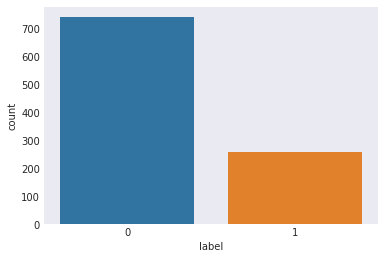

In [38]:
# label distribution
sns.countplot(x=sample_df['label']);

In [39]:
sample_df[['i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10', 'i11', 'i12', 'i13']] = sample_df[['i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10', 'i11', 'i12', 'i13']].astype(dtype = 'int32')
sample_df['label'] = sample_df['label'].astype(dtype = 'object')

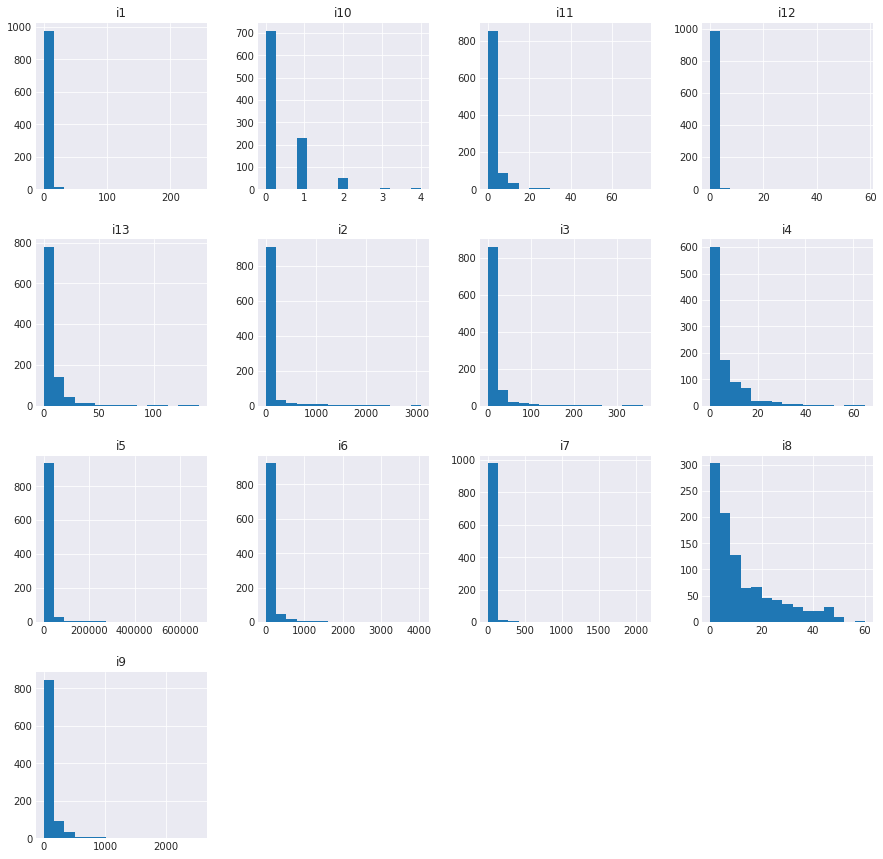

In [40]:
sample_df.hist(figsize=(15,15), bins=15)
plt.show()

> Since the matrix is very sparse, we change zero values into NaN for EDA, so that our bar graphs are not skewed towards 0.

In [41]:
sample_df[['i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10', 'i11', 'i12', 'i13']] = sample_df[['i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10', 'i11', 'i12', 'i13']].replace(0, np.NaN)
sample_df['label'] = sample_df['label'].astype(dtype = 'object')

In [42]:
sample_df.head(5)

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11,i12,i13,label
0,NaN,6.0,93.0,5.0,5863.0,NaN,NaN,34.0,273.0,NaN,NaN,NaN,20.0,NaN
1,NaN,NaN,25.0,3.0,20897.0,63.0,1.0,3.0,11.0,NaN,1.0,NaN,3.0,NaN
2,NaN,1.0,NaN,NaN,6107.0,182.0,5.0,NaN,137.0,NaN,1.0,NaN,NaN,NaN
3,1.0,40.0,22.0,29.0,335.0,122.0,1.0,22.0,118.0,1.0,1.0,NaN,104.0,NaN
4,NaN,NaN,4.0,NaN,3224.0,46.0,13.0,9.0,125.0,NaN,2.0,NaN,NaN,NaN


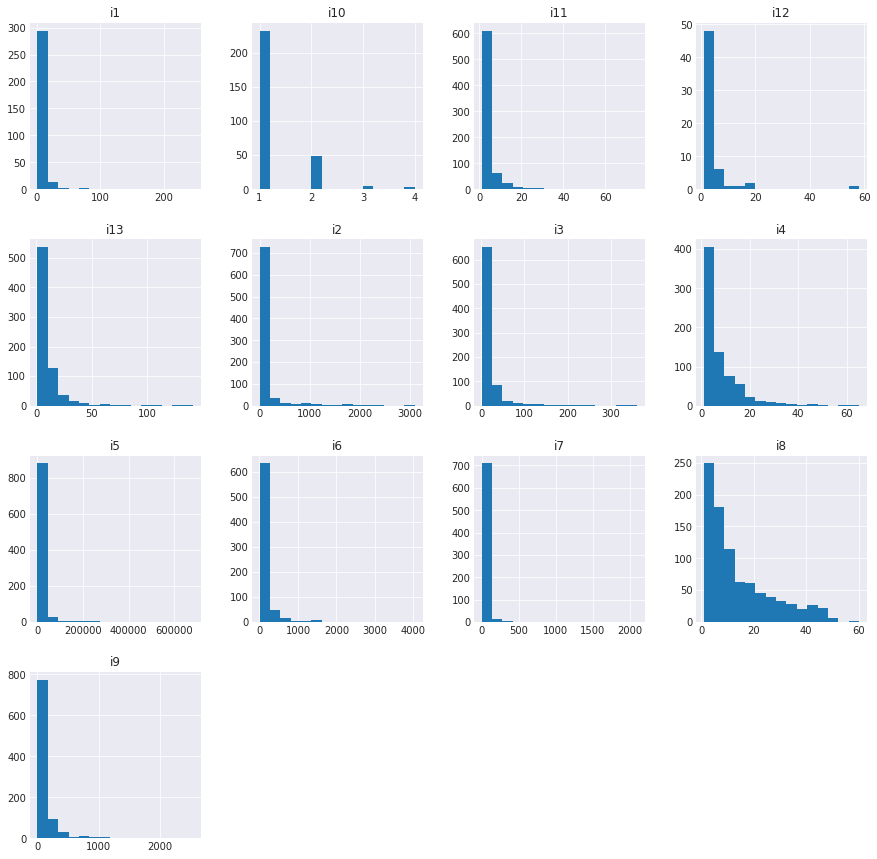

In [43]:
sample_df.hist(figsize=(15,15), bins=15)
plt.show()

In [44]:
y = sample_df['label']
y = y.replace(np.NaN, 0)
y.unique()

array([0., 1.])

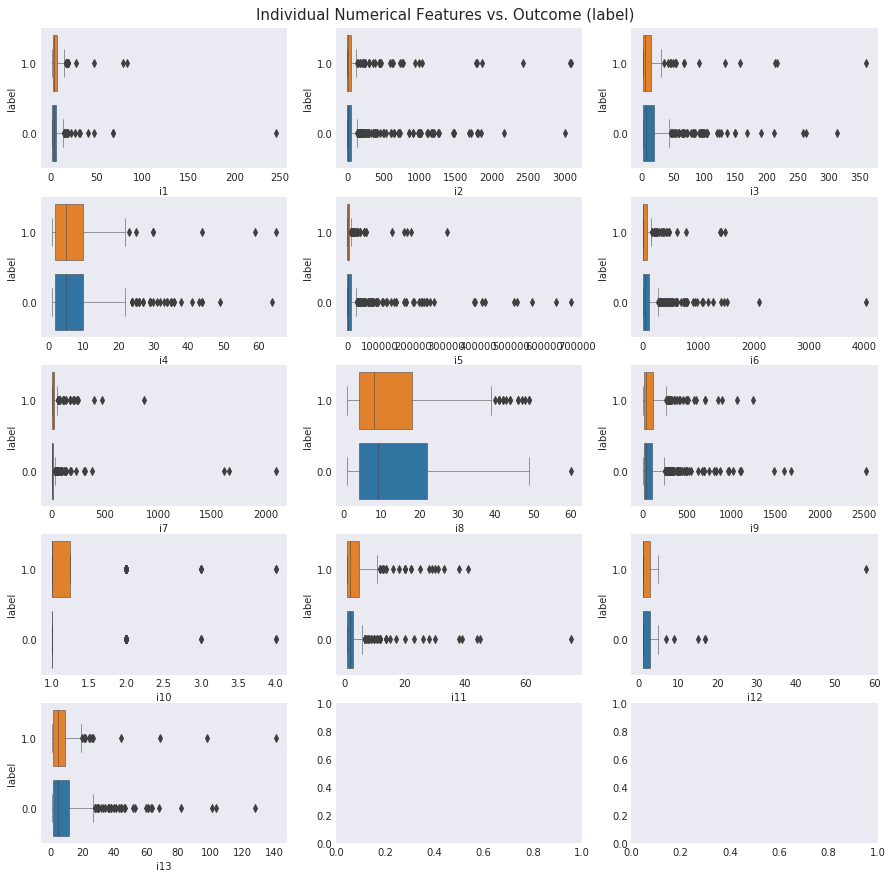

In [45]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
for idx, feature in enumerate(FIELDS[:-1]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Numerical Features vs. Outcome (label)", fontsize=15, y=0.9)
plt.show()

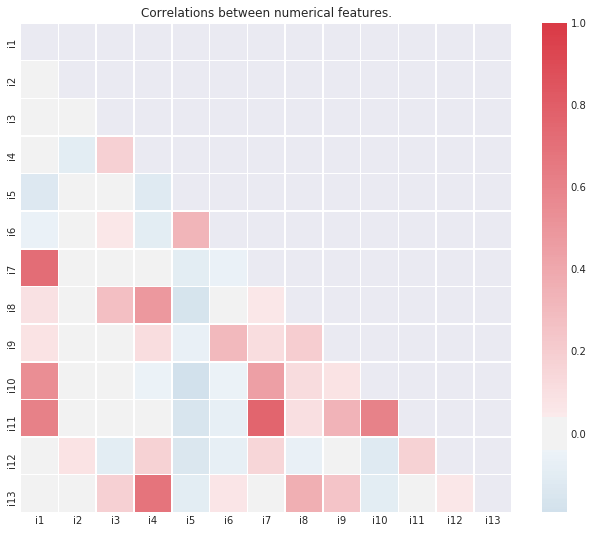

In [46]:
# plot heatmap for correlations matrix 
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between numerical features.")
plt.show()

## 3.2 EDA Categorical Features

In [47]:
# create a dataframe of all categorical features, better to understand them
cats = []
for i in range(len(catfeatRDD.take(1)[0][0])):
    cats.append('c'+str(i))
sample1 = catfeatRDD.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 50000)

In [48]:
cats.append('label')

In [49]:
sample_df_c = pd.DataFrame(np.array(sample1), columns = cats)
sample_df_c.head(10)

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c17,c18,c19,c20,c21,c22,c23,c24,c25,label
0,05db9164,80e26c9b,e346a5fd,85dd697c,25c83c98,7e0ccccf,3bac37e5,361384ce,a73ee510,030e1fe4,...,005c6740,21ddcdc9,5840adea,7e5b7cc4,ad3062eb,32c7478e,1793a828,e8b83407,b9809574,0
1,05db9164,8db5bc37,da22d7b6,9d7b7150,25c83c98,fbad5c96,a7709056,0b153874,a73ee510,d41c797d,...,821c30b8,,,2ba3a9ff,ad3062eb,32c7478e,03a47055,,,0
2,05db9164,558b4efb,b009d929,c7043c4b,2c6b8ded,7e0ccccf,282b88fc,0b153874,a73ee510,0f1a2599,...,c68ebaa0,21ddcdc9,5840adea,2754aaf1,ad3062eb,bcdee96c,3b183c5c,ea9a246c,ff86d5e0,1
3,05db9164,2c16a946,6e2b21ca,6ad68ce1,4cf72387,7e0ccccf,4b0cab49,062b5529,a73ee510,1fcfcb5a,...,74ef3502,,,a0770bf8,,423fab69,9117a34a,,,0
4,05db9164,ea3a5818,437d1adc,c312f2d6,25c83c98,,c5ab72ad,0b153874,a73ee510,3b08e48b,...,a1d0cc4f,c63ea0b4,b1252a9d,8fbbacc7,,32c7478e,85695ec3,1575c75f,63ef9236,1
5,05db9164,064c8f31,43a795a8,be13fbd1,25c83c98,,4aa938fc,0b153874,a73ee510,efea433b,...,3987fb8a,21ddcdc9,5840adea,45fdf300,,3a171ecb,a6e7d8d3,001f3601,2fede552,0
6,39af2607,89ddfee8,13d96fd5,cb1720f6,25c83c98,7e0ccccf,15eea2bb,0b153874,a73ee510,0ed4b00d,...,5bb2ec8e,b8ec925a,a458ea53,1484128d,,423fab69,df4a061e,f0f449dd,95faf097,0
7,05db9164,287130e0,b1bb2358,9f5d9f9f,43b19349,fbad5c96,63b212f8,c8ddd494,a73ee510,991fc4a4,...,891589e7,21ddcdc9,b1252a9d,7b8bb630,,bcdee96c,6696102c,ea9a246c,ef01189b,0
8,8cf07265,89ddfee8,9fef48d7,7f374353,25c83c98,fbad5c96,ad3508b1,0b153874,a73ee510,28bd0575,...,5bb2ec8e,21ddcdc9,a458ea53,134a4d00,,c7dc6720,c431714d,e8b83407,7731cc40,0
9,05db9164,04e09220,b1ecc6c4,5dff9b29,4cf72387,fbad5c96,8379baa1,0b153874,a73ee510,3b08e48b,...,6fc84bfb,,,4f1aa25f,,423fab69,ded4aac9,,,1


In [50]:
# unique entries
sample_df_c.groupby('label').agg(pd.Series.nunique)

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25
label,,,,,,,,,,,,,,,,,,,,,
0,344,477,19029,11907,97,12,6003,153,3,7276,...,10,1912,937,4,16670,9,14,6540,46,4983
1,198,396,7681,5133,67,9,3453,101,2,3790,...,9,1338,604,4,6878,9,12,3033,44,2332


In [51]:
#non-zero entries
sample_df_c.groupby('label').agg(np.count_nonzero)

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25
label,,,,,,,,,,,,,,,,,,,,,
0,37144,37144,35955,35955,37144,32743,37144,37144,37144,37144,...,37144,37144,21136,21136,35955,8532,37144,35955,21136,21136
1,12856,12856,12368,12368,12856,11275,12856,12856,12856,12856,...,12856,12856,6901,6901,12368,3328,12856,12368,6901,6901


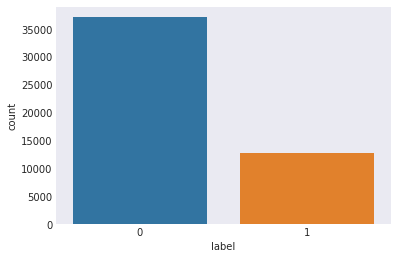

In [52]:
# label distribution
sns.countplot(x=sample_df_c['label']);

## 3.3 EDA Observations on Parallel Computing

From the histogram of samples drawn from training set, we can see that all of the integer features are skewed distribution to the left, and concentrated around values close to 0. This simple EDA tells us to normalize integer features before training with Logistic Regression model for better prediction.

**Note on Parallel Computing: In the process of normalizing integer features, processes of calculating mean and variance of each feature cannot be parallelized, since we need to know the count of all values in 13 integer columns in order to calculate the mean and variance (in section 4.2). However, normalization process can be parallelized by broadcasting `featureMeans` and `featureStdev` variables.**

From EDA for categorical features, we find that each categorical variable includes different # of unique categories. This finding is important to note for conducting one-hot encoding. We've decided to look at only top 20 categories for each column, but we now know that the length of one-hot vector is maximum $26 * 20 = 520$.  Instead, given that not all categorical variables have 20 uniqe features, we have one-hot vector representation with ca. $452$ across the 26 categorical features. This finding is applied when building `OneHot` function.

**Note on Parallel Computing: Similarly in handling categorical variables, obtaining top 20 categorical variables also faces scaling limitation. Iterating through all the values in 26 categorical variables in `countByValue` function and sorting the result cannot be parallelized, because we need to compare the counts of every category in one setting. However, once we broadcast `TC` variable, One-Hot Encoding process can be parallelized.**

# 4. Algorithm Implementation 

## 4.1 Define Regression Helper Functions

In [53]:
def getintfeatures(line):
    """
    Preprocess integer features: replace '' with zeroes and
    transform them to integers.
    Input: (label, integer_features, categorical_features)
    Output: ((label, processed integer_features, categorical_features))
    """
    
    intfeatures = line[1]
    
    for i in range(len(intfeatures)):
        if intfeatures[i] == '':
            intfeatures[i] = '0'
    intfeatures = list(map(int, intfeatures))
    
    return line[0], intfeatures, line[2]

In [54]:
def OneHot(line):
    """
    One-hot encodes the top-20 factors for each
    categorical feature. Categorical variables that
    had less n>20 features get n-1 dummy variables
    to avoid multicolinearity issues.
    Input: (label, integer_features, categorical_features)
    Output: (label, integer_features, I(categorical_features))
    """
    
    newline = []
    for i in range(26):
        if len(TC.value[i]) == 20:
            for j in TC.value[i]:
                if line[2][i] == j:
                    newline.append(1)
                else:
                    newline.append(0)
        else:
            for j in TC.value[i][1:]:
                if line[2][i] == j:
                    newline.append(1)
                else:
                    newline.append(0)      
                    
    return line[0], line[1], newline

In [55]:
def normalize(line):
    """
    Scale and center data round mean of each feature.
    Input: (label, integer_features, categorical_features)
    Output: (label, normalized_integer_features, categorical_features)
    """

    normalized = (line[1]-featureMeans.value)/featureStdev.value
    
    return line[0], normalized, line[2]

In [56]:
def logisticRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=5, regParam=0.01, regType=None, logloss=False):
    """
    Run a logistic regression using Gradient Descent with the option
    of regularization and outputs the log loss at each iteration.
    Input: (features, labels)
    Output: weights
    """
    
    featureLen = len(data.take(1)[0][0])
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen)
    else:
        w = wInitial
    for i in range(iterations):
        W = sc.broadcast(w)
        gradient = data.map(lambda d: (1 / (1 + np.exp(-d[1]*np.dot(W.value, d[0])))-1) * d[1] * np.array(d[0]))\
                    .reduce(lambda x, y: x + y)
        
        if regType == "Ridge":
            gradient[1:] += regParam * np.sign(W.value[1:])
            
        elif regType == "Lasso":
            gradient[1:] += regParam * 2 * W.value[1:]
               
        w = w - learningRate * gradient / n
        
        if logloss == True:
            log_loss = data.map(lambda d: np.log(np.exp(-d[1] * np.dot(w, d[0]))+1)).reduce(lambda x, y: x + y)
            print("Mean Logloss after",i+1, "iteration: ", log_loss/n)
        
    return w

## 4.2 Normalize Integer Feature Space around Mean / Reduce Categorical Feature Space

In [57]:
#Obtain the top-20 categories for each one of the categorical
#features. The number of top categories (20) was determined
#as it captures the most important categories and reduces the
#cardinality of the model.
topCats = []

for i in range(len(cleantrainRDD.take(1)[0][2])):
    d = cleantrainRDD.map(lambda x: x[2][i]).countByValue()
    topCats.append(sorted(d, key=d.get, reverse=True)[:20])

TC = sc.broadcast(topCats)

In [58]:
# Calculate and broadcast the means and variances of the training data
featureMeans = sc.broadcast(cleantrainRDD.map(getintfeatures).map(lambda x: np.array(x[1])).mean())
featureStdev = sc.broadcast(np.sqrt(cleantrainRDD.map(getintfeatures).map(lambda x: np.array(x[1])).variance()))

# Prepare the RDD to apply the regression. Modify the labels to (-1,1) from (0,1)
# in order to be able to apply the GD formulation of the logistic regression functions
AnalysisRDD = cleantrainRDD \
              .map(OneHot) \
              .map(getintfeatures) \
              .map(normalize) \
              .map(lambda x: (np.append(1,np.append(x[1],x[2])),float(x[0])*2-1))
# @Would be a good place to cache AnalysisRDD too (maybe unpersist cleantrainRDD).

## 4.3 Run Regression Models without and with Regularization (Ridge and Lasso)

In [59]:
# Calculate the weights of the regression without regularization
weights = logisticRegressionGDReg(AnalysisRDD, iterations=5)

In [60]:
# Calculate the weights of the regression with Ridge regularization
weights_ridge = logisticRegressionGDReg(AnalysisRDD, iterations=5, regType="Ridge")

In [61]:
# Calculate the weights of the regression with Lasso regularization
weights_lasso = logisticRegressionGDReg(AnalysisRDD, iterations=5, regType="Lasso")

In [62]:
# Calculate the weights of the regression with Lasso regularization
weights_lasso = logisticRegressionGDReg(AnalysisRDD, iterations=10, regType="Lasso")

In [63]:
weights

array([ 1.17265343, -1.44311509,  0.18857431,  0.56759321, -2.20557324,
       -0.3511823 ,  0.84020017,  0.6280003 ,  1.44937475, -0.1340351 ,
       -0.15259755, -0.85979217, -0.04741749, -1.47513046, -0.57547573,
        0.63831309, -0.46114595,  0.7431763 , -0.64409375, -1.23039353,
       -0.75672163, -1.77419456, -1.04535417, -0.39033482, -0.74097887,
       -1.0107042 ,  0.3913575 ,  0.24900229, -0.12130046,  0.67856613,
       -0.83153001,  0.271265  , -1.70310208, -0.21020132, -1.18190544,
        1.96703726, -1.02953484, -0.19958511,  0.38691413,  0.88920077,
        0.42519   , -0.18788364,  0.87874805, -1.46846682,  0.16464239,
       -0.76825413, -0.52528421, -1.60848312,  0.58694321, -2.09058723,
       -0.07430905, -0.28874983, -1.8290093 , -0.81434434, -0.65721019,
       -0.38289533, -0.41960459,  1.36079373,  0.81033873, -1.0208774 ,
        1.25965321, -0.31757118,  0.27384834, -0.09553035,  0.37550623,
       -1.08952471, -0.56645085, -0.74674827, -1.69979732, -0.36

In [64]:
weights_ridge

array([-1.14290680e+00,  9.09533410e-02, -2.91940742e-01,  2.42858284e-01,
        2.51286901e-02,  5.78917779e-01, -1.46756825e+00,  1.39177118e+00,
        6.33589064e-02,  8.58131125e-02,  1.52095289e+00,  1.17906872e-01,
       -8.61203202e-01,  5.38541599e-02,  1.26031502e+00, -1.48945584e+00,
        4.85909226e-01, -1.28445869e+00,  1.12979104e-01, -4.22810023e-01,
        1.92336380e+00,  1.15427759e+00,  7.40224933e-01,  2.94371964e-01,
       -7.17856218e-02, -9.08380107e-01,  1.04162339e+00,  9.77425888e-01,
       -6.94809407e-01, -7.42937385e-01,  1.08041926e+00, -9.80398956e-01,
        4.39718193e-01,  1.65163833e+00, -2.50023022e-01,  2.04792558e+00,
        8.53412102e-01, -7.95604204e-01,  3.77616130e-01, -8.58205367e-01,
        9.61926876e-01, -5.14783894e-01, -2.37849882e-02, -1.08975599e+00,
        2.81975878e-01,  1.71487610e+00, -1.09354832e+00, -1.02787548e+00,
       -8.98833929e-01, -1.43337337e+00, -2.13421549e-01,  2.94680672e-01,
        8.52295049e-01, -

In [65]:
weights_lasso

array([ 5.28520430e-01, -6.58885789e-01,  5.40976528e-01,  9.12250878e-01,
       -6.80332548e-01, -5.64551358e-03, -1.10134791e+00, -1.04806298e+00,
       -7.33478464e-01,  6.74885770e-01,  2.85488845e-01, -1.81279589e-01,
       -1.35267939e+00,  7.34969884e-01, -9.42939859e-01, -2.89813391e-02,
       -2.19560152e-01,  8.91450207e-01, -1.07412656e-01, -5.32140658e-01,
        1.92294347e-01, -3.33679955e-01,  6.76624846e-01,  2.13113928e+00,
       -2.80218165e+00, -9.09333743e-01,  9.79368220e-01,  5.98417656e-01,
        6.81992050e-01,  2.10344152e-01,  7.42163113e-01,  7.02290050e-01,
       -5.23972344e-01,  6.83242017e-01, -9.93981284e-01, -2.25159058e-02,
       -2.47476879e+00,  8.70801821e-01,  3.95688023e-01, -5.26922056e-01,
        3.02388681e-01, -1.39467686e-01, -1.38045325e+00, -7.31603621e-01,
       -1.08458370e-01, -4.02131801e-01,  1.26173189e+00,  7.19859840e-01,
        3.97351171e-01, -1.14600611e+00,  1.03189372e+00, -7.00989336e-01,
       -1.48397292e-01,  

## 4.4 Testing on test set

In [66]:
def prediction_logistic(x):
    """
    Transform the log odds into probabilities for the prediction.
    Input: (features, labels)
    Output: predictions
    """
    
    prob = 1/(1+np.exp(np.dot(Wlog.value,x[0])))

    if prob > 0.5:
        return 1
    else:
        return 0

def prediction_ridge(x):
    """
    Transform the log odds into probabilities for the prediction.
    Input: (features, labels)
    Output: predictions
    """
    
    prob = 1/(1+np.exp(np.dot(Wridge.value,x[0])))

    if prob > 0.5:
        return 1
    else:
        return 0
    
def prediction_lasso(x):
    """
    Transform the log odds into probabilities for the prediction.
    Input: (features, labels)
    Output: predictions
    """
    
    prob = 1/(1+np.exp(np.dot(Wlasso.value,x[0])))

    if prob > 0.5:
        return 1
    else:
        return 0

In [67]:
#Transform the heldOutRDD to the same structure as the training set to calculate metrics.
testRDD = heldOutRDD.map(lambda x: parse(x)) \
              .map(OneHot) \
              .map(getintfeatures) \
              .map(normalize) \
              .map(lambda x: (np.append(1,np.append(x[1],x[2])),float(x[0])))

In [68]:
def metrics(true, pred):
    """
    Assess the performance of the model through the accuracy and f1-scores.
    """
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(len(true)):
        if true[i] == pred[i]:
            if true[i] == 0:
                tn += 1
            else:
                tp += 1
        else:
            if true[i] == 0:
                fp += 1
            else:
                fn += 1
    
    accuracy = (tn+tp)/(tp+tn+fn+fp)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-Score: ", f1)

In [69]:
#Broadcast the weights and calculate the estimated values of each regression.
Wlog = sc.broadcast(weights)
Wridge = sc.broadcast(weights_ridge)
Wlasso = sc.broadcast(weights_lasso)

true = testRDD.map(lambda x: x[1]).collect()
pred_logistic = testRDD.map(prediction_logistic).collect()
pred_ridge = testRDD.map(prediction_ridge).collect()
pred_lasso = testRDD.map(prediction_lasso).collect()

In [70]:
metrics(true,pred_logistic)

Accuracy:  0.5586005736773565
Precision:  0.2777122115014741
Recall:  0.451504054207086
F1-Score:  0.343898498407451


In [71]:
metrics(true,pred_ridge)

Accuracy:  0.43470430593973236
Precision:  0.22814106992094557
Recall:  0.5061819952846375
F1-Score:  0.31452342286599944


In [72]:
metrics(true,pred_lasso)

Accuracy:  0.34898287726779753
Precision:  0.25744529972252644
Recall:  0.8177654562653954
F1-Score:  0.39160670932376396


## 4.5 Alogirithm Conclusions

#### Source: 1) Shanahan, James G. (2015). Linear Classification via gradient descent at scale [PDF slides], slides 350 - 366.
#### Source: 2) Shanahan, James G. (2015). [Distributed Logistic Regression.](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3e1bsvpvqbf97u1/LogisticRegression-Notebook.ipynb)

The implementation of logistic regression with and without regularization revealed the importance of parallelization as well as the value of the application of best practices such as broadcasting variables and cacheing RDDs to solve problems on big data. In particular, the statistical analysis of a dataset with as many rows and columns as this one would be impossible on most single node computers. However, by defining the problem as the embarrassingly parallel task of fitting the logistic model through gradient descent it is possible to use a cluster with commoditized hardware to obtain a solution. Nevertheless, the implementation of the model on Spark provided several challenges. First, the size of the RDDs made it crucial to be judicious on how and where to cache in order to avoid depleting our resources. Second, broadcasting variables so that workers had them ready to perform their jobs was paramount for better performance, however, this meant that we sometimes had to depart from functional programming best practices. For example, we created three prediction functions (one for each model: logistic, logistic with ridge regularization, and logistic with lasso regularization) in order to guarantee the broadcasting of the proper weights to each function. Third, some of the features we commonly use locally on Python are not designed to work on a cluster, therefore, we had to define functions that provided metrics such as the accuracy and f1 scores. Moreover, while we were able to obtain solutions for our models, the jobs took a considerable amount of time to be completed which prevented us from having a more robust size of iterations of the gradient descent algorithm or to fine-tune the regularization hyper-parameter. Finally, the results highlighted the importance of defining the adequate objective metric in a project. In particular, in the prediction of CTR rates it is much more important to detect those consumers that will actually click-through (true positives) than those who won't (true negatives) given that the former are the ones of who provide the revenue for ad agencies and advertisers. Therefore, while we could have obtained a better accuracy by simply predicting each observation as 0 (no click-through), our model is better suited to detect those consumers that matter the most to Criteo.

# 5 Application of Course Concepts 

### 5.1 One Hot Encoding
One-Hot Encoding is a process that takes categorical variables and converts their entries into binary vectors, so that better prediction is enabled when fed into ML algorithm. Each entry of a categorical variable that includes N categorical features can be represented as binary vectors of length N. If an entry in the variable takes $i^{th}$ categorical value out of N categories, the one-hot vector will take value 1 for the $i^{th}$ index, and 0s for all the other indices ([$0_0$, $0_1$, $0_2$, $1_{i-1}$, .... $0_{N-1}$]).
For example, let's say that there is a column named 'color', whose entries are 'blue', 'blue', and 'white'. One-Hot encoding converts them into vectors whose entries are 'is_blue' and 'is_white', and its final representation will be [1,0], [1,0], and [0,1].

In our project, One-Hot Encoding is used to represent all of 26 categorical variables into one-hot vector for each row of data. We notice the number of unique categories differ from one variable to another. First we take the top categorical features of each of 26 variables, up to 20 features, i.e. there are variables that have fewer than 20 unique categorical features. Then we encode each categorical variable with one-hot vectors with length N, where $N \leq 20$. Finally we append one-hot vectors of all 26 categorical variables to each other, and end up with one-hot encoded vector of length 465. For each row of data, now we have 13 integer features and 1 feature of one-hot vector.


### 5.2 Gradient Descent
Gradient Descent is an iterative learning process that seeks to find optimal parameters for a model given a particular training data set, so that prediction can be optimized. The process first starts at a random place in the Model Parameter Space and moves down the error surface to find a minimum point with the optimal parameters for training data. It is like walking down a hill until you don't have any more downhills to go. The 'size' of each step can be controlled by a hyperparameter, the learning rate $\alpha$. If learning rate is too small, it might take a long time to reach to local minimum. On the other hand, if learning rate is too large, we may never reach local minimum.
The process can be summarized in 3 steps of 1) initializing the parameters, 2) computing the gradient $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$, and 3) updating the parameters $\theta_{\text{new}} = \theta_{\text{old}} - \eta \cdot \nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) $.

In our project, Gradient Descent is applied in finding optimal parameters of our logistic regression model, by taking the derivative of cost function of logistic regression. It is applied in function `logisticRegressionGD` with a rule-of-thumb learning rate of 0.5. We iterate 5 times to find the best parameters, and we reach the F-1 score of 0.392 with these optimal parameters with Lasso regularization.

### 5.3 Bias-Variace Tradeoff / Model complexity / Regularization
#### Source: [Bias-Variance Tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html)
Bias-variance trade off is a property of machine learning model, such that bias is reduced and variance is increased in relation to model complexity. As more parameters are added to a model, the complexity of model and variance increase while bias steadily falls, resulting in overfitting. It is impossible for a machine learning algorithm to capture the regularities in training datasets more accurately, as well as to generalize well in other datasets at the same time.
Regularization enables us to avoid overfitting and train generalizable model without manual feature selection, by penalizing the model for excessive complexity. Lasso and Ridge regularization both reduce the variance of the model by reducing the coefficients of some features towards 0, without much increase in bias. while Lasso regularization shrinks weights of less important features to 0 and removes those features altogether, Ridge regularization reduces the size of weights toward 0.

We try both Lasso and Ridge regularization in this project, as well as without regularization. F-1 scores for three predictions are as below:
- No regularization: 0.344
- Lasso regularization: 0.392
- Ridge regularization: 0.315

We can see that Lasso regularization has helped not to overfit to training set and improved generalizability of our model to test set by F-1 score of 0.05, after 10 iterations. On the other hand, Ridge regularization has not made improvements to F-1 score. It may be because we've only run 5 iterations for vanilla logistic regression and with Ridge regularization due to time constraints.

### 5.4 Functional Programming / Higher Order Functions / Map Reduce Paradigm
A key feature of functional languages is the concept of higher-order functions, or functions that can accept other functions as arguments. Moreover, functional programming also involves the idea that the output value of a function depends only on the arguments that are input to that function. `map` and `reduce` can be thought of as higher-order functions, and they are used extensively in parallel programming, especially the map phase.
The map phase consists of having a function mapped (or applied) to each line of input. The reduce phase is an aggregation, where a summation, or average, or grouping is performed on the input data.  The map phase lends itself to a lot of parallelism because we can have the same function applied to different chunks of that, running at the same time, independently of each other.

In our project, we utilised this paradigm of MapReduce to our benefit to parallelise as much tasks as possible. We had helper functions for One-Hot Encoding, Parsing Input to get Integer Features, and Normalisation. These tasks were achieved in parallel on the dataset, with the help of broadcasting variables (variance and mean for normalisation). Furthermore, our algorithmic implementation of Logistic Regression involved having to compute gradient for all the input data points. The most efficient way to achieve that was using MapReduce framework: map was used to calculate gradient for each point, and reduce was used to sum up these. Finally the updated parameters/weights matrix was calculated.

On a final note, we initially wrote our code on a single node, relatively high performing virtual server.  WHen we switched to testing on the IBM Analytics engine using a 3 node cluster we noticed a significant increase in job times.  This is due to the overhead from networking shuffling the data across network.  This increased cost of I/O increased our processing times significantly.  As we tried to judiciously implement caching of RDDs used for repeated transformations, we experienced endless infrastructure errors with time out disconnects.  We present our final code with limited caching as we lacked the technical expertise to trouble shoot and resolve the connection errors.  Specifically, we would want to cache our trainRDD used for the various data processing and, even more critical the AnalysisRDD we used to loop over the iterations for reducing the log-loss cost of our regression.  Given more time and infrastructure experience, this is one area we would look to optimize for performance given our solution.